## Working with Audio Files Using Transformer Models
### Learning Objectives
- Load and preprocess audio files (WAV/FLAC)

- Use Hugging Face pretrained transformer models for speech recognition and audio classification

- Analyze model outputs: transcriptions or audio class labels

- Visualize attention weights (optional)

- Run the entire workflow inside Google Colab

In [1]:
# Step 1: Setup Environment and Imports
# Install required libraries
!pip install transformers datasets torchaudio librosa soundfile -q

import torch
import torchaudio
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline, Wav2Vec2ForCTC, Wav2Vec2Processor, HubertForSequenceClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.1 MB/s eta 0:00:00
Using device: cuda


In [2]:
# Step 2: Load and Listen to an Audio Sample
# Load an example audio file from URL (can be replaced with your own audio upload)
audio_url = "https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/mlk.flac"
audio_path = "sample_audio.flac"

# Download audio sample
import requests
with open(audio_path, "wb") as f:
    f.write(requests.get(audio_url).content)

# Load audio with librosa (sampling rate 16kHz required)
speech, sr = librosa.load(audio_path, sr=16000)

print(f"Loaded audio shape: {speech.shape}, Sample rate: {sr}")

# Listen inline (only in Colab/Jupyter)
import IPython.display as ipd
ipd.display(ipd.Audio(data=speech, rate=sr))


Loaded audio shape: (208000,), Sample rate: 16000


In [3]:
# Step 3: Speech Recognition with Wav2Vec2
# Load processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)

# Preprocess audio: tokenize
inputs = processor(speech, sampling_rate=sr, return_tensors="pt", padding=True).to(device)

# Inference
with torch.no_grad():
    logits = model(inputs.input_values).logits

# Take argmax and decode predicted ids to text
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)[0]
print("Transcription:", transcription)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Transcription: I HAVE A DREAM BUT ONE DAY THIS NATION WILL RISE UP LIVE UP THE TRUE MEANING OF ITS TREES


In [4]:
# Step 4: Audio Classification with Hubert
# Using pretrained Hubert model (audio classification on speech commands / emotions)

# Load pretrained Hubert classification model and processor
classifier = pipeline(
    task="audio-classification",
    model="superb/hubert-large-superb-er",
    device=0 if torch.cuda.is_available() else -1,  # Use GPU if available, else CPU
)

# Classify audio from the file (can also pass raw waveform or filepath)
result = classifier(audio_path)

print("Audio Classification Results:")
for r in result:
    print(f"Label: {r['label']}, Score: {r['score']:.4f}")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Audio Classification Results:
Label: hap, Score: 0.6716
Label: neu, Score: 0.1255
Label: sad, Score: 0.1244
Label: ang, Score: 0.0785


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


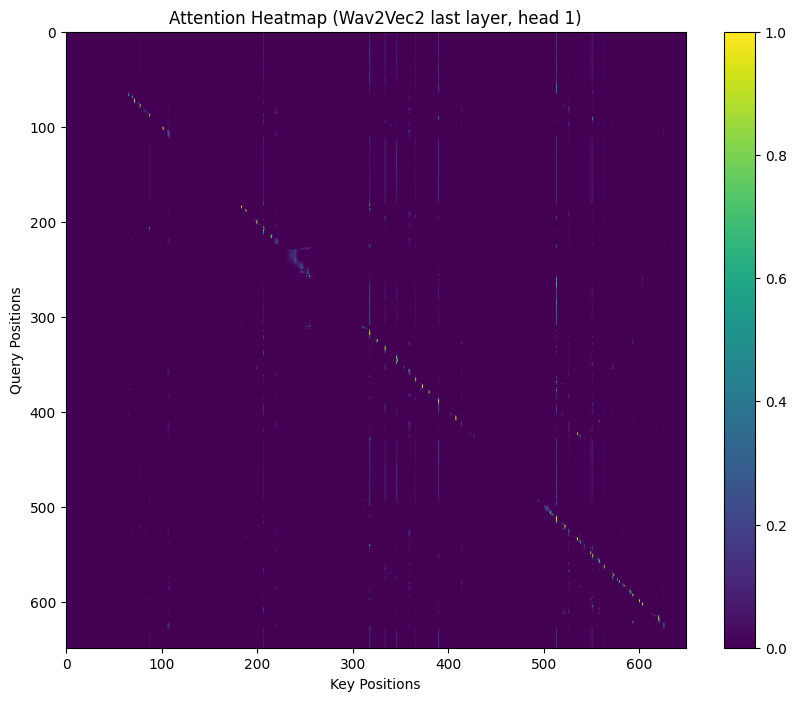

In [5]:
# Step 5: Optional - Visualize Attention Weights (Advanced)

# Requires loading model with output_attentions=True and extracting attention weights
# Example for speech recognition Wav2Vec2:

model_att = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h", output_attentions=True).to(device)
outputs = model_att(inputs.input_values)

# Get attentions from last layer (for example)
attentions = outputs.attentions[-1].cpu().detach().numpy()  # Shape: (batch_size, num_heads, seq_len, seq_len)

# Plot attention map of first head and first batch entry
plt.figure(figsize=(10, 8))
plt.imshow(attentions[0, 0], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Attention Heatmap (Wav2Vec2 last layer, head 1)")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()


### Replace audio_path with your uploaded file path to run inference.

- Transformers models like facebook/wav2vec2-base-960h are pretrained on 16kHz audio; ensure resampling if needed.

- The audio-classification pipeline supports various models available on Hugging Face Hub.